In [ ]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import time

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from PIL import Image, ImageSequence
from IPython import display
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def resize_vid(width, height, n_pools = 4):
  if(width > 300):
    ratio = 256.0/width
    width = 256
    height *= ratio
  if(height > 300):
    ratio = 256.0/height
    height = 256
    width *= ratio #muze zlobit, muze zmenit na float

  width = int(width)
  height = int(height)
  w = width - (width % np.power(2,n_pools))#abych mohl vyuzivat pooling a pak zpet do stejneho rozliseni
  h = height - (height % np.power(2,n_pools))
  return w, h

#https://stackoverflow.com/questions/33311153/python-extracting-and-saving-video-frames
def load_video(location):
  vidcap = cv2.VideoCapture(location)
  success,image = vidcap.read()
  width  = vidcap.get(3) # float
  height = vidcap.get(4) # float
  width, height = resize_vid(width, height)
  frames = []
  while success:
    image = cv2.resize(image,(width,height),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
    frames.append(image) 
    success,image = vidcap.read()
  frames = np.array(frames)/256.0 #normalize
  return frames

In [ ]:
def U_Net_model(input_shape):
  input = layers.Input(input_shape)
  return U_Net_defined_input(input_shape, input)

def U_Net_defined_input(input_shape, input):
  convblock_1 = layers.Conv2D(32, 3, activation='relu', padding='same')(input)
  convblock_1 = layers.BatchNormalization()(convblock_1)
  convblock_1 = layers.Conv2D(32, 3, activation='relu', padding='same')(convblock_1)
  convblock_1 = layers.BatchNormalization()(convblock_1)
  convblock_1_2 = layers.MaxPooling2D(pool_size=2)(convblock_1)

  convblock_2 = layers.Conv2D(64, 3, activation='relu', padding='same')(convblock_1_2)
  convblock_2 = layers.BatchNormalization()(convblock_2)
  convblock_2 = layers.Conv2D(64, 3, activation='relu', padding='same')(convblock_2)
  convblock_2 = layers.BatchNormalization()(convblock_2)
  convblock_2_3 = layers.MaxPooling2D(pool_size=2)(convblock_2)

  convblock_3 = layers.Conv2D(128, 3, activation='relu', padding='same')(convblock_2_3)
  convblock_3 = layers.BatchNormalization()(convblock_3)
  convblock_3 = layers.Conv2D(128, 3, activation='relu', padding='same')(convblock_3)
  convblock_3 = layers.BatchNormalization()(convblock_3)
  convblock_3_4 = layers.MaxPooling2D(pool_size=2)(convblock_3)

  convblock_4 = layers.Conv2D(256, 3, activation='relu', padding='same')(convblock_3_4)
  convblock_4 = layers.BatchNormalization()(convblock_4)
  convblock_4 = layers.Conv2D(256, 3, activation='relu', padding='same')(convblock_4)
  convblock_4 = layers.BatchNormalization()(convblock_4)
  convblock_4_5 = layers.MaxPooling2D(pool_size=2)(convblock_4)

  block_5 = layers.Conv2D(512, 3, activation='relu', padding='same')(convblock_4_5)
  block_5 = layers.BatchNormalization()(block_5)
  block_5 = layers.Conv2D(512, 3, activation='relu', padding='same')(block_5)
  block_5 = layers.BatchNormalization()(block_5)

  deconvblock_4 = layers.UpSampling2D(size=2)(block_5)
  #deconvblock_4 = layers.Conv2DTranspose(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(block_5)
  #deconvblock_4 = layers.Conv2D(256, 3, activation='relu', padding='same')(deconvblock_4)
  #deconvblock_4 = layers.BatchNormalization()(deconvblock_4)
  deconvblock_4 = layers.concatenate([deconvblock_4, convblock_4], axis=3)
  deconvblock_4 = layers.Conv2D(256, 3, activation='relu', padding='same')(deconvblock_4)
  deconvblock_4 = layers.BatchNormalization()(deconvblock_4)
  deconvblock_4 = layers.Conv2D(256, 3, activation='relu', padding='same')(deconvblock_4)
  deconvblock_4 = layers.BatchNormalization()(deconvblock_4)

  deconvblock_3 = layers.UpSampling2D(size=2)(deconvblock_4)
  #deconvblock_3 = layers.Conv2D(128, 3, activation='relu', padding='same')(deconvblock_3)
  #deconvblock_3 = layers.BatchNormalization()(deconvblock_3)
  deconvblock_3 = layers.concatenate([deconvblock_3, convblock_3], axis=3)
  deconvblock_3 = layers.Conv2D(128, 3, activation='relu', padding='same')(deconvblock_3)
  deconvblock_3 = layers.BatchNormalization()(deconvblock_3)
  deconvblock_3 = layers.Conv2D(128, 3, activation='relu', padding='same')(deconvblock_3)
  deconvblock_3 = layers.BatchNormalization()(deconvblock_3)

  deconvblock_2 = layers.UpSampling2D(size=2)(deconvblock_3)
  #deconvblock_2 = layers.Conv2D(64, 3, activation='relu', padding='same')(deconvblock_2)
  #deconvblock_2 = layers.BatchNormalization()(deconvblock_2)
  deconvblock_2 = layers.concatenate([deconvblock_2, convblock_2], axis=3)
  deconvblock_2 = layers.Conv2D(64, 3, activation='relu', padding='same')(deconvblock_2)
  deconvblock_2 = layers.BatchNormalization()(deconvblock_2)
  deconvblock_2 = layers.Conv2D(64, 3, activation='relu', padding='same')(deconvblock_2)
  deconvblock_2 = layers.BatchNormalization()(deconvblock_2)

  deconvblock_1 = layers.UpSampling2D(size=2)(deconvblock_2)
  #deconvblock_1 = layers.Conv2D(32, 3, activation='relu', padding='same')(deconvblock_1)
  #deconvblock_1 = layers.BatchNormalization()(deconvblock_1)
  deconvblock_1 = layers.concatenate([deconvblock_1, convblock_1], axis=3)
  deconvblock_1 = layers.Conv2D(32, 3, activation='relu', padding='same')(deconvblock_1)
  deconvblock_1 = layers.BatchNormalization()(deconvblock_1)
  deconvblock_1 = layers.Conv2D(32, 3, activation='relu', padding='same')(deconvblock_1)
  deconvblock_1 = layers.BatchNormalization()(deconvblock_1)


  output = layers.Conv2D(input_shape[2]/2, 3, activation='sigmoid', padding='same')(deconvblock_1)


  model = models.Model(input, output, name='u_net')
  #display(model.summary())
  return model

In [ ]:
def split_frames(frames):
  X, y = list(), list()
  for i in range(frames.shape[0] - 2):
    X.append(np.concatenate((frames[i], frames[i+2]), axis=2))
    y.append(frames[i+1])
  return np.array(X),np.array(y)

In [ ]:
import imageio
def create_gif(frames, filename):
  with imageio.get_writer(filename, mode='I') as writer:
    for frame in frames:
      writer.append_data(frame)
      display.clear_output(wait=True)
    writer.append_data(frame)
  return

#create_gif(generated_images, '/content/drive/My Drive/kocka_mp4/GAN/generated_3000.gif')

In [ ]:
def batch_split(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        yield X[i:i + batch_size], y[i:i + batch_size]

In [ ]:
def disc_input(real_input, fake_input):
  y_real = np.ones((real_input.shape[0]))
  y_fake = np.zeros((fake_input.shape[0]))
  y = np.concatenate([y_real, y_fake], axis = 0)
  X = np.concatenate([real_input, fake_input], axis = 0)
  return X, y


In [ ]:
def make_generator_model(input_shape):
  model = tf.keras.Sequential()
  model.add(layers.Input(input_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.0))
  model.add(layers.Conv2D(96, (5, 5), activation='relu', padding='same', kernel_constraint=tf.keras.constraints.MaxNorm(20)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.0))
  model.add(layers.Conv2D(48, 3, activation='relu', padding='same', kernel_constraint=tf.keras.constraints.MaxNorm(20)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.0))
  model.add(layers.Conv2D(24, 3, activation='relu', padding='same', kernel_constraint=tf.keras.constraints.MaxNorm(20)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.0))
  model.add(layers.Conv2D(12, 3, activation='relu', padding='same', kernel_constraint=tf.keras.constraints.MaxNorm(20)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.0))
  model.add(layers.Conv2D(input_shape[2]/2, (5, 5), padding='same', kernel_constraint=tf.keras.constraints.MaxNorm(20)))
  return model

In [ ]:
frames = load_video('/content/drive/My Drive/kocka.mp4')
frames.shape

(159, 256, 128, 3)

(157, 256, 128, 6)
(157, 256, 128, 3)


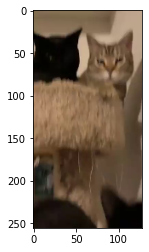

In [ ]:
X,y = split_frames(frames)
print(X.shape)
print(y.shape)
#RGB_img = cv2.cvtColor(frames[100], cv2.COLOR_BGR2RGB)
plt.imshow(frames[90][:, :, ::-1])

In [ ]:
model = make_generator_model(X[0].shape)
checkpoint_filepath = '/content/drive/My Drive/kocka_a_anime/GAN/gen_trained_by_gan'
#model = U_Net_model(X[0].shape)
#checkpoint_filepath = '/content/drive/My Drive/kocka_mp4/U_Net/u_net_4'
#generator.summary()
model.load_weights(checkpoint_filepath)
#generated_image = generator(X, training=False)

In [ ]:
interpolated_frames = interpolate_frames(frames, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


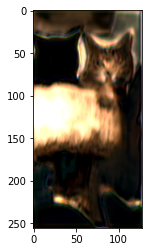

In [ ]:
plt.imshow(interpolated_frames[181][:, :, ::-1])

In [ ]:
def make_discriminator_model(input_shape):
  model = tf.keras.Sequential()
  model.add(layers.Input(input_shape))
  model.add(layers.Conv2D(24, (5, 5), strides=(2, 2), activation='relu', padding='same'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(48, (5, 5), strides=(2, 2), activation='relu', padding='same'))
  model.add(layers.Dropout(0.3))
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Conv2D(96, (5, 5), strides=(2, 2), activation='relu', padding='same'))
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

In [ ]:
discriminator = make_discriminator_model(y[0].shape)
#discriminator.summary()
checkpoint_filepath = '/content/drive/My Drive/kocka_mp4/GAN/discriminator/disc'
discriminator.load_weights(checkpoint_filepath)
decision = discriminator(generated_image[50:51])
print (decision)
decision = discriminator(y[50:51])
print (decision)

tf.Tensor([[0.547009]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5508573]], shape=(1, 1), dtype=float32)


In [ ]:
class SSIM(tf.keras.losses.Loss):
  def call(self, y_true, y_pred):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    result = []
    arr = []
    for i in range(y_pred.shape[0]):
      image1 = y_true[i]
      image2 = y_pred[i]
      score, grad = ssim(image1, image2, data_range=image2.max() - image2.min(), multichannel=True, gradient = True)
      if i == 0:
        arr = grad.reshape((1, grad.shape[0], grad.shape[1], grad.shape[2]))
      else:
        arr = np.concatenate([arr, grad.reshape((1, grad.shape[0], grad.shape[1], grad.shape[2]))], axis = 0)
      result.append(1.0 - score)
    #arr = np.mean(arr, axis=-1)
    return tf.math.reduce_mean(tf.constant(arr), axis=-1)

In [ ]:
#https://www.tensorflow.org/tutorials/generative/dcgan
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mean_squared_error = tf.keras.losses.mean_squared_error

def discriminator_loss(real_output, fake_output):
  real_loss = bce(tf.ones_like(real_output), real_output)
  fake_loss = bce(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  fake_loss = bce(tf.ones_like(fake_output), fake_output)
  return fake_loss

In [ ]:
@tf.function
def train_step(input, images):
  gen_loss, disc_loss = 0, 0
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(input, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss, disc_loss


In [ ]:
def train(dataset, epochs):
  X,y = split_frames(dataset)
  best_gen = 9999999
  for epoch in range(epochs):
    start = time.time()
    gen_loss, disc_loss = 0, 0
    for Xb, yb in batch_split(X, y, 64):
      gl, dl = train_step(Xb,yb)
      gen_loss += gl.numpy()
      disc_loss += dl.numpy()
    cur_ep = epoch + 14001

    display.clear_output(wait=True)
    if cur_ep % 500 == 0:
      generate_and_save_gif(generator, cur_ep, X)
      display.clear_output()

    # Save the model every 20 epochs
    if cur_ep % 20 == 0:
      manager.save(checkpoint_number=1)
    print ('Time for epoch', cur_ep, 'is', time.time()-start)
    print ('Gen loss:', gen_loss)
    print ('Disc loss:', disc_loss)
  display.clear_output(wait=True)

In [ ]:
def generate_and_save_gif(model, epoch, input):
  generated_images = model.predict(input)
  create_gif(generated_images[:, :, :, ::-1], '/content/drive/My Drive/kocka_mp4/GAN/generated/generated_' + str(epoch) + '.gif')

In [ ]:
EPOCHS = 500000
lr_gen = 1e-4
lr_dis = 1e-4
generator_optimizer = tf.keras.optimizers.Adam(lr_gen)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_dis)

In [ ]:

checkpoint_prefix = '/content/drive/My Drive/kocka_mp4/GAN/gan'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(checkpoint, directory = checkpoint_prefix, max_to_keep = 1)

manager.restore_or_initialize()
#generator.load_weights('/content/drive/My Drive/kocka_mp4/GAN/generator/gen_3')
#discriminator.load_weights('/content/drive/My Drive/kocka_mp4/GAN/discriminator/disc')

train(frames, EPOCHS)

Time for epoch 16461 is 1.1143112182617188


KeyboardInterrupt: ignored

In [ ]:
#samostatne uceni jednotlivych modelu
#dX, dy = disc_input(frames, generated_images)
input = X[0]
model = make_generator_model(input.shape)
checkpoint_filepath = '/content/drive/My Drive/kocka_mp4/GAN/generator/gen_3'
#input = dX[0]
#model = make_discriminator_model(input.shape)
#checkpoint_filepath = '/content/drive/My Drive/kocka_mp4/GAN/discriminator/disc'
model.load_weights(checkpoint_filepath)

In [ ]:
history = []
early_stopping_callback = callbacks.EarlyStopping(monitor='val_loss', patience=20)
model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_loss',
      mode='min',
      save_best_only=True)
i = 0
lrates = [1e-3,1e-4,1e-5]
while True:
  model.load_weights(checkpoint_filepath)
  i = i+1
  i = i%3
  optimizer = optimizers.Adam(lr = lrates[i], beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)
  model.compile(optimizer=optimizer, loss='mse')
  epochs = model.fit(X, y, batch_size=64, epochs=100000, callbacks=[model_checkpoint_callback, early_stopping_callback], validation_split = 0.2)
  history.append(epochs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


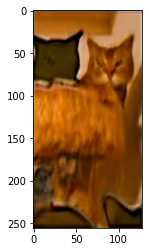

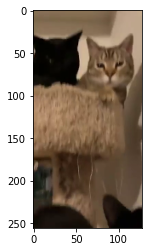

In [ ]:
#model.load_weights(checkpoint_filepath)
#model = generator
generated_images = model.predict(X)
plt.imshow(generated_images[90][:, :, ::-1])
plt.show()
plt.imshow(y[90][:, :, ::-1])

In [ ]:
create_gif(generated_images[:, :, :, ::-1], '/content/drive/My Drive/kocka_mp4/GAN/generator/generated/generated_5000.gif')

In [ ]:
def interpolation_input(frames):
  X = list()
  for i in range(frames.shape[0] - 1):
    X.append(np.concatenate((frames[i], frames[i+1]), axis=2))
  return np.array(X)

def join_frames(output, interpolated_frames):
  result = []
  result.append(output[0])
  for i in range(1, output.shape[0]):
    result.append(interpolated_frames[i - 1])
    result.append(output[i])

  return np.array(result)

In [ ]:
#Generuj "zpomalene video"
def interpolate_frames(frames, n_times, predict_all = False):
  output = frames.copy()

  for i in range(n_times):
    input = interpolation_input(output)
    interpolated_frames = model.predict(input)
    if i == 0 and predict_all:
      output = join_frames(model.predict(X), interpolated_frames)
    else:
      output = join_frames(output, interpolated_frames)
  return output

#interpolated_frames = interpolate_frames(frames, 1)

In [ ]:
create_gif(interpolated_frames[:, :, :, ::-1], '/content/drive/My Drive/kocka_mp4/GAN/generator/generated/interpolated_3.gif')

In [ ]:
h = history
his = pd.read_csv('/content/drive/My Drive/kocka_mp4/GAN/generator/hist.csv')
#pd.DataFrame(h[0].history)
print(his)
for i in range( len(h)):
  print(h[i].history)
  his = pd.concat([his, pd.DataFrame(h[i].history)], axis=0, ignore_index=True)
pd.DataFrame(his).to_csv('/content/drive/My Drive/kocka_mp4/GAN/generator/hist.csv')